In [ ]:
import torch
from all_code import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 32000,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 384,        # Embedding dimension
    "n_heads": 6,         # Number of attention heads9992413436
    "n_layers": 6,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval();

In [2]:
from all_code import generate_text_simple
from bpe import HindiTokenizer

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "ऑनलाइन क्लास में हमेशा अपने पोस्चर"
tokenizer = HindiTokenizer()
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(start_context, tokenizer),
max_new_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 ऑनलाइन क्लास में हमेशा अपने पोस्चर फोनancowryलीलसंस्थान const घटनास्थल क्रेता भालू ट्रेडर्स निरा


In [3]:
file_path = '/home/angkul/my_data/coding/agi/hindi_GPT/hindi.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [4]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 36506
Tokens: 9207


In [5]:
from all_code import create_dataloader

total_characters = len(text_data)
train_ratio = 0.80
split_idx = int(train_ratio*total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [6]:
torch.manual_seed(32)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [7]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [8]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss/num_batches

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)


torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(10.5416, device='cuda:0')
Validation loss: tensor(10.5428, device='cuda:0')


In [10]:
!nvidia-smi

Thu May 15 22:46:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0              7W /   30W |     804MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()

In [12]:
from tqdm import tqdm

In [13]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [14]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="ऑनलाइन क्लास में हमेशा अपने पोस्चर", tokenizer=tokenizer
)

  0%|          | 0/10 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 10.240, Val loss 10.294
Ep 1 (Step 000005): Train loss 8.955, Val loss 9.057
Ep 1 (Step 000010): Train loss 8.159, Val loss 8.340


 10%|█         | 1/10 [00:02<00:20,  2.27s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर है। है। है। है। है। है। है। है। है। है। है। है। है।। है। है। है।। है। है। है। है। है। है। है। है।
Ep 2 (Step 000015): Train loss 7.295, Val loss 7.750
Ep 2 (Step 000020): Train loss 6.863, Val loss 7.385
Ep 2 (Step 000025): Train loss 6.415, Val loss 7.233


 20%|██        | 2/10 [00:04<00:17,  2.24s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर है। के है। के और है। के है। के है। के है। के है। के। के है।। के है। के है।। के है। के है। के है। के है। के है। के
Ep 3 (Step 000030): Train loss 6.244, Val loss 7.179
Ep 3 (Step 000035): Train loss 6.011, Val loss 7.187
Ep 3 (Step 000040): Train loss 5.838, Val loss 7.131


 30%|███       | 3/10 [00:06<00:15,  2.24s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर है। ⁇  के लिए है। ⁇  के लिए है। ⁇  में है। ⁇  के लिए है। ⁇  में है। ⁇ । ⁇  के लिए है। ⁇  में यह और हैं। ⁇  है। ⁇  में, के लिए के लिए है।
Ep 4 (Step 000045): Train loss 5.691, Val loss 7.062
Ep 4 (Step 000050): Train loss 5.628, Val loss 7.010


 40%|████      | 4/10 [00:08<00:13,  2.24s/it]

Ep 4 (Step 000055): Train loss 5.421, Val loss 7.032
ऑनलाइन क्लास में हमेशा अपने पोस्चर में यह के लिए है। ⁇  के लिए है। ⁇  के लिए है। ⁇  के लिए के लिए है। ⁇  में, और के लिए है। ⁇  के लिए यह में, में यह है। ⁇  में, के लिए के लिए है।
Ep 5 (Step 000060): Train loss 5.153, Val loss 7.001
Ep 5 (Step 000065): Train loss 5.007, Val loss 6.942


 50%|█████     | 5/10 [00:11<00:10,  2.17s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर में यह के लिए यह आवश्यक के लिए से एक के लिए यह आवश्यक के लिए यह के लिए के लिएों के लिए है। ⁇ ने के लिएों को के लिए यह आवश्यक के लिए है। ⁇  में, यह के लिए के लिएों का
Ep 6 (Step 000070): Train loss 4.746, Val loss 6.971
Ep 6 (Step 000075): Train loss 4.525, Val loss 6.939
Ep 6 (Step 000080): Train loss 4.508, Val loss 6.940


 60%|██████    | 6/10 [00:13<00:08,  2.20s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर में यह आवश्यक होता है। ⁇ मोर, और यह भी कर्मचारी के लिएों का पर निर्भर के लिएों को चाहिए। ⁇ मोर, कर्मचारी की तरह से एक- में, और, यह आवश्यक है। ⁇ मोर की तरह से में, कर्मचारी
Ep 7 (Step 000085): Train loss 4.240, Val loss 6.930
Ep 7 (Step 000090): Train loss 4.173, Val loss 6.930
Ep 7 (Step 000095): Train loss 4.073, Val loss 6.960


 70%|███████   | 7/10 [00:15<00:06,  2.22s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर में एक बड़ा से एक कि वह एक बड़ा की तरह एक विशेषों को एक विशेष की तरह से एक- 18 एक- 1000000000000000000000
Ep 8 (Step 000100): Train loss 3.743, Val loss 6.909
Ep 8 (Step 000105): Train loss 3.595, Val loss 6.934
Ep 8 (Step 000110): Train loss 3.324, Val loss 6.960


 80%|████████  | 8/10 [00:17<00:04,  2.24s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर में यह आवश्यक होता है। ⁇ मोर और भारत के लिए यह आवश्यक होता है। ⁇ मोर के साथ के लिए यह आवश्यक होता है। ⁇ मोर और मोर के लिए यह आवश्यक होता है। ⁇ मोरों का, यह आवश्यक के लिए यह आवश्यक
Ep 9 (Step 000115): Train loss 3.204, Val loss 6.929
Ep 9 (Step 000120): Train loss 3.002, Val loss 6.948


 90%|█████████ | 9/10 [00:20<00:02,  2.24s/it]

Ep 9 (Step 000125): Train loss 2.853, Val loss 6.943
ऑनलाइन क्लास में हमेशा अपने पोस्चर में ही नहीं होती हैं। ⁇ मोर को चाहिए। ⁇ नेतृत्व की तरह से अधिक के लिए यह भी अपनी अ पेकोक, कर्मचारी की तरह से होता है। ⁇ मोर अपने कार्य के साथ में, जिसे की तरह से आवाज के लिए
Ep 10 (Step 000130): Train loss 2.790, Val loss 6.967
Ep 10 (Step 000135): Train loss 2.467, Val loss 7.010


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर में एक बड़ा और कर्मचारी का चुनाव होती है। यह भी कर्मचारी पर निर्भर करता है। यह आवश्यक है। इससे कर्मचारी और नेता का, कर्मचारी की कोशिश की तरह से होता है। ⁇ मोर और पर बने है। कर्मचारियों के लिए यह आवश्यक है


In [15]:
def to_cpu_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x

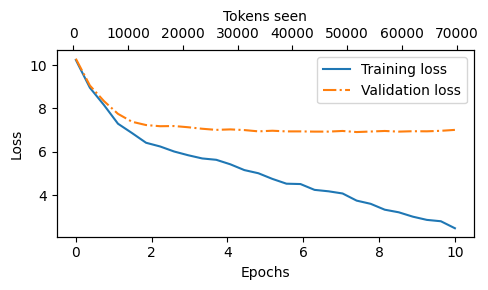

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(
    epochs_tensor.cpu(),
    tokens_seen,
    [loss.item() for loss in train_losses],
    [loss.item() for loss in val_losses]
)

In [17]:
model.to("cuda")
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("ऑनलाइन क्लास में हमेशा अपने पोस्चर", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 ऑनलाइन क्लास में हमेशा अपने पोस्चर में एक बड़ा और कर्मचारी का चुनाव होती है। यह भी कर्मचारी पर निर्भर करता है। यह आवश्यक है। इससे कर्मचारी और


In [18]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  

            idx_next = torch.multinomial(probs, num_samples=1)

        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [20]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("I read पुस्तकालय में books", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I read पुस्तकालय में books रंगें पर निर्भरता हो रंग का मादा का उपयोग को भी देते हैं
